In [3]:
import json

# Define the input and output file names
input_file = 'results_nlp.json'
output_file = 'results_CL.json'

# Load the JSON data from the input file
with open(input_file, 'r') as file:
    data = json.load(file)

# Filter out keys that start with 'cl-'
filtered_data = {key: value for key, value in data.items() if key.startswith('cl-') or key == 'reproduction-align-pythia+410m'}

# Write the filtered data to the output file
with open(output_file, 'w') as file:
    json.dump(filtered_data, file, indent=4)

print(f"Filtered data has been written to {output_file}")

Filtered data has been written to results_CL.json


In [6]:
import json
import numpy as np

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ]
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in vl_datasets])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_delta_nlg = change["lambada_standard"]
        avg_acc_nlg = current_results.get("lambada_standard", np.nan)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NLU': avg_delta_nlu, 'NLG': avg_delta_nlg}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NLU': avg_acc_nlu, 'NLG': avg_acc_nlg}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'sgm': 'SGM',
    'sgm-rehearsal1': 'SGM Rehearsal',
    'sgm-olf': 'SGM OLF',
    'rehearsal1': 'Rehearsal1',
    'lora': 'LoRA',
    'naive-ft': 'Naive FT',
    'soft': 'Soft',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{8}{c|}{\\textbf{Vision-Language (VL)}} & \\multicolumn{8}{c}{\\textbf{NLU/NLG}} \\\\
     & \\multicolumn{2}{c|}{\\textbf{Instruct (0)}} & \\multicolumn{2}{c|}{\\textbf{VQA (1)}} & \\multicolumn{2}{c|}{\\textbf{OCR (2)}} & \\multicolumn{2}{c|}{\\textbf{Ref (3)}} & \\multicolumn{2}{c|}{\\textbf{Instruct (0)}} & \\multicolumn{2}{c|}{\\textbf{VQA (1)}} & \\multicolumn{2}{c|}{\\textbf{OCR (2)}} & \\multicolumn{2}{c}{\\textbf{Ref (3)}} \\\\
     & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['VL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['VL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['VL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['VL'] * 100,
    tasks['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100,
    tasks['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100,
    tasks['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100,
    tasks['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_vl_d:.2f} & {t1_vl_a:.2f} & {t1_vl_d:.2f} & {t2_vl_a:.2f} & {t2_vl_d:.2f} & {t3_vl_a:.2f} & {t3_vl_d:.2f} & {t0_nlu_a:.2f} & {t0_nlu_d:.2f} & {t1_nlu_a:.2f} & {t1_nlu_d:.2f} & {t2_nlu_a:.2f} & {t2_nlu_d:.2f} & {t3_nlu_a:.2f} & {t3_nlu_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_vl_d=model_results[2],
    t1_vl_a=model_results[3], t1_vl_d=model_results[4],
    t2_vl_a=model_results[5], t2_vl_d=model_results[6],
    t3_vl_a=model_results[7], t3_vl_d=model_results[8],
    t0_nlu_a=model_results[9], t0_nlu_d=model_results[10],
    t1_nlu_a=model_results[11], t1_nlu_d=model_results[12],
    t2_nlu_a=model_results[13], t2_nlu_d=model_results[14],
    t3_nlu_a=model_results[15], t3_nlu_d=model_results[16]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['VL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['VL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['VL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['VL'] * 100,
        tasks['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100,
        tasks['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100,
        tasks['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100,
        tasks['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_vl_d:.2f} & {t1_vl_a:.2f} & {t1_vl_d:.2f} & {t2_vl_a:.2f} & {t2_vl_d:.2f} & {t3_vl_a:.2f} & {t3_vl_d:.2f} & {t0_nlu_a:.2f} & {t0_nlu_d:.2f} & {t1_nlu_a:.2f} & {t1_nlu_d:.2f} & {t2_nlu_a:.2f} & {t2_nlu_d:.2f} & {t3_nlu_a:.2f} & {t3_nlu_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_vl_d=model_results[2],
        t1_vl_a=model_results[3], t1_vl_d=model_results[4],
        t2_vl_a=model_results[5], t2_vl_d=model_results[6],
        t3_vl_a=model_results[7], t3_vl_d=model_results[8],
        t0_nlu_a=model_results[9], t0_nlu_d=model_results[10],
        t1_nlu_a=model_results[11], t1_nlu_d=model_results[12],
        t2_nlu_a=model_results[13], t2_nlu_d=model_results[14],
        t3_nlu_a=model_results[15], t3_nlu_d=model_results[16]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \label{tab:vl_nlu_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}
     \toprule
     \textbf{Model} & \multicolumn{8}{c|}{\textbf{Vision-Language (VL)}} & \multicolumn{8}{c}{\textbf{NLU/NLG}} \\
     & \multicolumn{2}{c|}{\textbf{Instruct (0)}} & \multicolumn{2}{c|}{\textbf{VQA (1)}} & \multicolumn{2}{c|}{\textbf{OCR (2)}} & \multicolumn{2}{c|}{\textbf{Ref (3)}} & \multicolumn{2}{c|}{\textbf{Instruct (0)}} & \multicolumn{2}{c|}{\textbf{VQA (1)}} & \multicolumn{2}{c|}{\textbf{OCR (2)}} & \multicolumn{2}{c}{\textbf{Ref (3)}} \\
     & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{

In [11]:
import json
import numpy as np

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ]
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in vl_datasets])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_delta_nlg = change["lambada_standard"]
        avg_acc_nlg = current_results.get("lambada_standard", np.nan)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NLU': avg_delta_nlu, 'NLG': avg_delta_nlg}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NLU': avg_acc_nlu, 'NLG': avg_acc_nlg}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'sgm': 'SGM',
    'sgm-rehearsal1': 'SGM Rehearsal',
    'sgm-olf': 'SGM OLF',
    'rehearsal1': 'Rehearsal1',
    'lora': 'LoRA',
    'naive-ft': 'Naive FT',
    'soft': 'Soft',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{6}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{6}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{6}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{6}{c|}{\\textbf{Task 3 (Ref)}} \\\\
     & \\multicolumn{2}{c|}{\\textbf{VL}} & \\multicolumn{2}{c|}{\\textbf{NLU}} & \\multicolumn{2}{c|}{\\textbf{NLG}} & \\multicolumn{2}{c|}{\\textbf{VL}} & \\multicolumn{2}{c|}{\\textbf{NLU}} & \\multicolumn{2}{c|}{\\textbf{NLG}} & \\multicolumn{2}{c|}{\\textbf{VL}} & \\multicolumn{2}{c|}{\\textbf{NLU}} & \\multicolumn{2}{c|}{\\textbf{NLG}} & \\multicolumn{2}{c|}{\\textbf{VL}} & \\multicolumn{2}{c|}{\\textbf{NLU}} & \\multicolumn{2}{c|}{\\textbf{NLG}} \\\\
     & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$}\\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['VL'] * 100,
    tasks['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100,
    tasks['stage_0_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['VL'] * 100,
    tasks['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100,
    tasks['stage_1_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['VL'] * 100,
    tasks['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100,
    tasks['stage_2_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['VL'] * 100,
    tasks['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100,
    tasks['stage_3_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_vl_d:.2f} & {t0_nlu_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_a:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_vl_d:.2f} & {t1_nlu_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_a:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_vl_d:.2f} & {t2_nlu_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_a:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_vl_d:.2f} & {t3_nlu_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_a:.2f} & {t3_nlg_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_vl_d=model_results[2],
    t0_nlu_a=model_results[3], t0_nlu_d=model_results[4],
    t0_nlg_a=model_results[5], t0_nlg_d=model_results[6],
    t1_vl_a=model_results[7], t1_vl_d=model_results[8],
    t1_nlu_a=model_results[9], t1_nlu_d=model_results[10],
    t1_nlg_a=model_results[11], t1_nlg_d=model_results[12],
    t2_vl_a=model_results[13], t2_vl_d=model_results[14],
    t2_nlu_a=model_results[15], t2_nlu_d=model_results[16],
    t2_nlg_a=model_results[17], t2_nlg_d=model_results[18],
    t3_vl_a=model_results[19], t3_vl_d=model_results[20],
    t3_nlu_a=model_results[21], t3_nlu_d=model_results[22],
    t3_nlg_a=model_results[23], t3_nlg_d=model_results[24]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['VL'] * 100,
        tasks['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100,
        tasks['stage_0_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['VL'] * 100,
        tasks['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100,
        tasks['stage_1_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['VL'] * 100,
        tasks['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100,
        tasks['stage_2_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['VL'] * 100,
        tasks['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100,
        tasks['stage_3_avg']['NLG'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_vl_d:.2f} & {t0_nlu_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_a:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_vl_d:.2f} & {t1_nlu_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_a:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_vl_d:.2f} & {t2_nlu_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_a:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_vl_d:.2f} & {t3_nlu_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_a:.2f} & {t3_nlg_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_vl_d=model_results[2],
        t0_nlu_a=model_results[3], t0_nlu_d=model_results[4],
        t0_nlg_a=model_results[5], t0_nlg_d=model_results[6],
        t1_vl_a=model_results[7], t1_vl_d=model_results[8],
        t1_nlu_a=model_results[9], t1_nlu_d=model_results[10],
        t1_nlg_a=model_results[11], t1_nlg_d=model_results[12],
        t2_vl_a=model_results[13], t2_vl_d=model_results[14],
        t2_nlu_a=model_results[15], t2_nlu_d=model_results[16],
        t2_nlg_a=model_results[17], t2_nlg_d=model_results[18],
        t3_vl_a=model_results[19], t3_vl_d=model_results[20],
        t3_nlu_a=model_results[21], t3_nlu_d=model_results[22],
        t3_nlg_a=model_results[23], t3_nlg_d=model_results[24]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \label{tab:vl_nlu_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}
     \toprule
     \textbf{Model} & \multicolumn{6}{c|}{\textbf{Task 0 (Instruct)}} & \multicolumn{6}{c|}{\textbf{Task 1 (VQA)}} & \multicolumn{6}{c|}{\textbf{Task 2 (OCR)}} & \multicolumn{6}{c|}{\textbf{Task 3 (Ref)}} \\
     & \multicolumn{2}{c|}{\textbf{VL}} & \multicolumn{2}{c|}{\textbf{NLU}} & \multicolumn{2}{c|}{\textbf{NLG}} & \multicolumn{2}{c|}{\textbf{VL}} & \multicolumn{2}{c|}{\textbf{NLU}} & \multicolumn{2}{c|}{\textbf{NLG}} & \multicolumn{2}{c|}{\textbf{VL}} & \multicolumn{2}{c|}{\textbf{NLU}} & \multicolumn{2}{c|}{\textbf{NLG}} & \multicolumn{2}{c|}{\textbf{VL}} & \multicolumn{2}{c|}{\textbf{NLU}} & \multicolumn{2}{c|}{\textbf{NLG}} \\
     & \textbf{A $\uparrow$} & 

In [18]:
import json
import numpy as np

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
    
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in vl_datasets])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_delta_nlg = change["lambada_standard"]
        avg_acc_nlg = current_results.get("lambada_standard", np.nan)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NLU': avg_delta_nlu, 'NLG': avg_delta_nlg}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NLU': avg_acc_nlu, 'NLG': avg_acc_nlg}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|ccc|ccc|ccc|ccc}
     \\toprule
     \\textbf{Model} & \\multicolumn{3}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{3}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{3}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{3}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} \\\\
     & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{A $\\uparrow$} & \\textbf{$\\Delta \\downarrow$} & \\textbf{$\\Delta \\downarrow$} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nlu_d=model_results[2], t0_nlg_d=model_results[3],
    t1_vl_a=model_results[4], t1_nlu_d=model_results[5], t1_nlg_d=model_results[6],
    t2_vl_a=model_results[7], t2_nlu_d=model_results[8], t2_nlg_d=model_results[9],
    t3_vl_a=model_results[10], t3_nlu_d=model_results[11], t3_nlg_d=model_results[12]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nlu_d=model_results[2], t0_nlg_d=model_results[3],
        t1_vl_a=model_results[4], t1_nlu_d=model_results[5], t1_nlg_d=model_results[6],
        t2_vl_a=model_results[7], t2_nlu_d=model_results[8], t2_nlg_d=model_results[9],
        t3_vl_a=model_results[10], t3_nlu_d=model_results[11], t3_nlg_d=model_results[12]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \label{tab:vl_nlu_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|ccc|ccc|ccc|ccc}
     \toprule
     \textbf{Model} & \multicolumn{3}{c|}{\textbf{Task 0 (Instruct)}} & \multicolumn{3}{c|}{\textbf{Task 1 (VQA)}} & \multicolumn{3}{c|}{\textbf{Task 2 (OCR)}} & \multicolumn{3}{c}{\textbf{Task 3 (Ref)}} \\
     & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} \\
     & \textbf{A $\uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{A $\uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{A $\uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{A $\uparrow$} & \textbf{$\Delta \uparrow$} & \textbf{$\Delta \uparrow$} \\
    

In [19]:
import json
import numpy as np

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in vl_datasets])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets if dataset != "lambada_standard"])
        avg_delta_nlg = change["lambada_standard"]
        avg_acc_nlg = current_results.get("lambada_standard", np.nan)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NLU': avg_delta_nlu, 'NLG': avg_delta_nlg}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NLU': avg_acc_nlu, 'NLG': avg_acc_nlg}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|ccc|ccc|ccc|ccc|ccc}
     \\toprule
     \\textbf{Model} & \\multicolumn{3}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{3}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{3}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{3}{c|}{\\textbf{Task 3 (Ref)}} & \\multicolumn{3}{c}{\\textbf{Avg.}} \\\\
     & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} & \\textbf{VL} & \\textbf{NLU} & \\textbf{NLG} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

# Calculate the average values across all tasks
avg_vl_a = np.mean([tasks[f'stage_{i}_avg']['VL'] for i in range(4)]) * 100
avg_nlu_d = np.mean([cl_performance_change[model_name][f'stage_{i}_avg']['NLU'] for i in range(4)]) * 100
avg_nlg_d = np.mean([cl_performance_change[model_name][f'stage_{i}_avg']['NLG'] for i in range(4)]) * 100

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100,
    avg_vl_a, avg_nlu_d, avg_nlg_d
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_d:.2f} & {avg_vl_a:.2f} & {avg_nlu_d:.2f} & {avg_nlg_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nlu_d=model_results[2], t0_nlg_d=model_results[3],
    t1_vl_a=model_results[4], t1_nlu_d=model_results[5], t1_nlg_d=model_results[6],
    t2_vl_a=model_results[7], t2_nlu_d=model_results[8], t2_nlg_d=model_results[9],
    t3_vl_a=model_results[10], t3_nlu_d=model_results[11], t3_nlg_d=model_results[12],
    avg_vl_a=model_results[13], avg_nlu_d=model_results[14], avg_nlg_d=model_results[15]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    # Calculate the average values across all tasks
    avg_vl_a = np.mean([tasks[f'stage_{i}_avg']['VL'] for i in range(4)]) * 100
    avg_nlu_d = np.mean([cl_performance_change[model_name][f'stage_{i}_avg']['NLU'] for i in range(4)]) * 100
    avg_nlg_d = np.mean([cl_performance_change[model_name][f'stage_{i}_avg']['NLG'] for i in range(4)]) * 100

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_0_avg']['NLG'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_1_avg']['NLG'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_2_avg']['NLG'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLU'] * 100, cl_performance_change[model_name]['stage_3_avg']['NLG'] * 100,
        avg_vl_a, avg_nlu_d, avg_nlg_d
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nlu_d:.2f} & {t0_nlg_d:.2f} & {t1_vl_a:.2f} & {t1_nlu_d:.2f} & {t1_nlg_d:.2f} & {t2_vl_a:.2f} & {t2_nlu_d:.2f} & {t2_nlg_d:.2f} & {t3_vl_a:.2f} & {t3_nlu_d:.2f} & {t3_nlg_d:.2f} & {avg_vl_a:.2f} & {avg_nlu_d:.2f} & {avg_nlg_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nlu_d=model_results[2], t0_nlg_d=model_results[3],
        t1_vl_a=model_results[4], t1_nlu_d=model_results[5], t1_nlg_d=model_results[6],
        t2_vl_a=model_results[7], t2_nlu_d=model_results[8], t2_nlg_d=model_results[9],
        t3_vl_a=model_results[10], t3_nlu_d=model_results[11], t3_nlg_d=model_results[12],
        avg_vl_a=model_results[13], avg_nlu_d=model_results[14], avg_nlg_d=model_results[15]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NLU/NLG tasks}
  \label{tab:vl_nlu_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|ccc|ccc|ccc|ccc|ccc}
     \toprule
     \textbf{Model} & \multicolumn{3}{c|}{\textbf{Task 0 (Instruct)}} & \multicolumn{3}{c|}{\textbf{Task 1 (VQA)}} & \multicolumn{3}{c|}{\textbf{Task 2 (OCR)}} & \multicolumn{3}{c|}{\textbf{Task 3 (Ref)}} & \multicolumn{3}{c}{\textbf{Avg.}} \\
     & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} & \textbf{VL} & \textbf{NLU} & \textbf{NLG} \\
     & \textbf{(A $\uparrow$)} & \textbf{($\Delta \uparrow$)} & \textbf{($\Delta \uparrow$)} & \textbf{(A $\uparrow$)} & \textbf{($\Delta \uparrow$)} & \textbf{($\Delta \uparrow$)} & \textbf{(A $\uparrow$)} & \textbf{($\Delta \uparrow$)} & \textbf{($\Delt

In [2]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        avg_delta_vl = hmean([current_results.get(dataset, np.nan) for dataset in vl_datasets]) - hmean([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_acc_vl = hmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_nl = hmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets]) - hmean([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_acc_nl = hmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances


# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c|}{\\textbf{Task 3 (Ref)}} & \\multicolumn{2}{c}{\\textbf{Avg.}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

# Calculate the average values across all tasks
avg_vl_a = hmean([tasks[f'stage_{i}_avg']['VL'] for i in range(4)]) * 100
avg_nl_d = hmean([cl_performance_change[model_name][f'stage_{i}_avg']['NL'] for i in range(4)]) * 100

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100,
    avg_vl_a, avg_nl_d
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} & {avg_vl_a:.2f} & {avg_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8],
    avg_vl_a=model_results[9], avg_nl_d=model_results[10]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    # Calculate the average values across all tasks
    avg_vl_a = hmean([tasks[f'stage_{i}_avg']['VL'] for i in range(4)]) * 100
    avg_nl_d = hmean([cl_performance_change[model_name][f'stage_{i}_avg']['NL'] for i in range(4)]) * 100

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100,
        avg_vl_a, avg_nl_d
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} & {avg_vl_a:.2f} & {avg_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8],
        avg_vl_a=model_results[9], avg_nl_d=model_results[10]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


In [15]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace zero and NaN values with a small positive value
def replace_zeros_and_nans(arr, epsilon=EPSILON):
    return [epsilon if (np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        # else if any of the values are NaN, say missing data
        elif any(np.isnan(list(current_results.values()))):
            missing_data = True
            print(f"Run '{run_id}' has NaN values for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = hmean([current_results.get(dataset, np.nan) for dataset in vl_datasets].append(EPSILON))
        baseline_vl_scores = hmean([baseline_results.get(dataset, np.nan) for dataset in vl_datasets].append(EPSILON))
        avg_delta_vl = vl_scores - baseline_vl_scores
        avg_acc_vl = vl_scores
        
        nl_scores = hmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets].append(EPSILON))
        baseline_nl_scores = hmean([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets].append(EPSILON))
        avg_delta_nl = nl_scores - baseline_nl_scores
        avg_acc_nl = nl_scores
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

In [11]:
cl_performance

Model: naive-ft, Stage: 0, VL: 4.9999912418323465e-09, NL: 0.386335211248867
Model: naive-ft, Stage: 1, VL: 4.99999988021291e-09, NL: 0.27008121708918353
Model: naive-ft, Stage: 2, VL: 4.999999880022329e-09, NL: 0.3426370297688389
Model: naive-ft, Stage: 3, VL: 4.999999797328891e-09, NL: 0.31516802053012133
Model: olf, Stage: 0, VL: 2.4999970052744294e-09, NL: 0.3862114768012791
Model: olf, Stage: 1, VL: 4.999999887339521e-09, NL: 0.33557058101554343
Model: olf, Stage: 2, VL: 4.99999981126311e-09, NL: 0.3561971402196864
Model: olf, Stage: 3, VL: 0.02052355334666818, NL: 0.3279029496019928
Model: soft, Stage: 0, VL: 2.499999533244665e-09, NL: 0.38408061774225954
Model: soft, Stage: 1, VL: 2.49999897472598e-09, NL: 0.24544255837751494
Model: soft, Stage: 2, VL: 4.999999804504593e-09, NL: 0.33810199783569805
Model: soft, Stage: 3, VL: 4.999996941646891e-09, NL: 0.2831706070762011
Model: ia3, Stage: 0, VL: 1.666665542224119e-09, NL: 0.4060056499199212
Model: ia3, Stage: 1, VL: 4.9999997806

In [16]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros and None values
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace None and NaN values with a small positive value
def replace_none_and_nans(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = replace_none_and_nans([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        baseline_vl_scores = replace_none_and_nans([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_vl = hmean(vl_scores) - hmean(baseline_vl_scores)
        avg_acc_vl = hmean(vl_scores)
        
        nl_scores = replace_none_and_nans([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        baseline_nl_scores = replace_none_and_nans([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_delta_nl = hmean(nl_scores) - hmean(baseline_nl_scores)
        avg_acc_nl = hmean(nl_scores)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


Model: naive-ft, Stage: 0, VL: 0.0018170996252468133, NL: 0.3863352100999474
Model: naive-ft, Stage: 1, VL: 0.004883015551323806, NL: 0.2700812156708484
Model: naive-ft, Stage: 2, VL: 0.004882833790224212, NL: 0.34263702858390443
Model: naive-ft, Stage: 3, VL: 0.004805223973421436, NL: 0.3151680192897782
Model: olf, Stage: 0, VL: 0.001137452877526601, NL: 0.38621147563923447
Model: olf, Stage: 1, VL: 0.004889822056584252, NL: 0.3355705798232125
Model: olf, Stage: 2, VL: 0.0048181282798036755, NL: 0.35619713904716904
Model: olf, Stage: 3, VL: 0.02052355010460835, NL: 0.3279029484150912
Model: soft, Stage: 0, VL: 0.0021066784919526577, NL: 0.38408061658239784
Model: soft, Stage: 1, VL: 0.0017729114713216957, NL: 0.2454425568378775
Model: soft, Stage: 2, VL: 0.004811860657475776, NL: 0.33810199662515095
Model: soft, Stage: 3, VL: 0.003102369722228088, NL: 0.2831706057243446
Model: ia3, Stage: 0, VL: 0.0009952229299363057, NL: 0.40600564872147704
Model: ia3, Stage: 1, VL: 0.004789865743612

In [21]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros and None values
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace None and NaN values with a small positive value
def replace_none_and_nans(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        # Print current results for this model for all datasets
        print(f"Model: {model_name}, Stage: {i}, Results: {current_results}")
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = hmean([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        baseline_vl_scores = hmean([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_vl = hmean(vl_scores) - hmean(baseline_vl_scores)
        avg_acc_vl = hmean(vl_scores)
        
        nl_scores = hmean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        baseline_nl_scores = hmean([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_delta_nl = hmean(nl_scores) - hmean(baseline_nl_scores)
        avg_acc_nl = hmean(nl_scores)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


Model: naive-ft, Stage: 0, Results: {'vqa-v2': 0.0037, 'textvqa-ocr': 0.005078124999999999, 'textvqa-pure': 0.003515625, 'gqa': 0.001, 'refcoco': 0.0, 'wsc273': 0.6556776556776557, 'winogrande': 0.5374901341752171, 'lambada_standard': 0.30293033184552687, 'arc_easy': 0.4831649831649832, 'arc_challenge': 0.23890784982935154}
Model: naive-ft, Stage: 0, VL: 0.0, NL: 0.3863352100999474
Model: naive-ft, Stage: 1, Results: {'vqa-v2': 0.5144, 'textvqa-ocr': 0.09843749999999998, 'textvqa-pure': 0.10781249999999998, 'gqa': 0.38770000000000004, 'refcoco': 0.0, 'wsc273': 0.5787545787545788, 'winogrande': 0.526440410418311, 'lambada_standard': 0.12381137201630119, 'arc_easy': 0.42508417508417506, 'arc_challenge': 0.22440273037542663}
Model: naive-ft, Stage: 1, VL: 0.0, NL: 0.2700812156708484
Model: naive-ft, Stage: 2, Results: {'vqa-v2': 0.45130000000000003, 'textvqa-ocr': 0.09863281249999999, 'textvqa-pure': 0.11962890624999997, 'gqa': 0.30469999999999997, 'refcoco': 0.0, 'wsc273': 0.608058608058

In [2]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = datasets

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "rehearsal10": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal10",
        "cl-ocr-stage-2-pythia+410m-rehearsal10",
        "cl-ref-stage-3-pythia+410m-rehearsal10"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_datasets])
        baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
        avg_delta_vl = hmean(vl_scores) - hmean(baseline_vl_scores)
        avg_acc_vl = hmean(vl_scores)
        
        nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_delta_nl = hmean(nl_scores) - hmean(baseline_nl_scores)
        avg_acc_nl = hmean(nl_scores)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'rehearsal10': 'Rehearsal \((10\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


Model: naive-ft, Stage: 0, VL: 0.0018170996252468133, NL: 0.3863352100999474
Model: naive-ft, Stage: 1, VL: 0.004883015551323806, NL: 0.2700812156708484
Model: naive-ft, Stage: 2, VL: 0.004882833790224212, NL: 0.34263702858390443
Model: naive-ft, Stage: 3, VL: 0.004805223973421436, NL: 0.3151680192897782
Model: olf, Stage: 0, VL: 0.001137452877526601, NL: 0.38621147563923447
Model: olf, Stage: 1, VL: 0.004889822056584252, NL: 0.3355705798232125
Model: olf, Stage: 2, VL: 0.0048181282798036755, NL: 0.35619713904716904
Model: olf, Stage: 3, VL: 0.02052355010460835, NL: 0.3279029484150912
Model: soft, Stage: 0, VL: 0.0021066784919526577, NL: 0.38408061658239784
Model: soft, Stage: 1, VL: 0.0017729114713216957, NL: 0.2454425568378775
Model: soft, Stage: 2, VL: 0.004811860657475776, NL: 0.33810199662515095
Model: soft, Stage: 3, VL: 0.003102369722228088, NL: 0.2831706057243446
Model: ia3, Stage: 0, VL: 0.0009952229299363057, NL: 0.40600564872147704
Model: ia3, Stage: 1, VL: 0.004789865743612

In [24]:
current_results

{'vqa-v2': 0.39659999999999995,
 'textvqa-ocr': 0.13886718750000002,
 'textvqa-pure': 0.07988281249999998,
 'gqa': 0.28809999999999997,
 'refcoco': 0.04296875,
 'wsc273': 0.5934065934065934,
 'winogrande': 0.510655090765588,
 'lambada_standard': 0.26683485348340774,
 'arc_easy': 0.4802188552188552,
 'arc_challenge': 0.2354948805460751}

In [25]:
vl_sequence_id = "ivor"
vl_evaluate_sequence = [["vqa-v2"],["vqa-v2","gqa"],["vqa-v2","gqa","textvqa-ocr","textvqa-pure"],["vqa-v2","gqa","textvqa-ocr","textvqa-pure","refcoco"]]

SyntaxError: invalid syntax (1068649868.py, line 1)

In [4]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "rehearsal10": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal10",
        "cl-ocr-stage-2-pythia+410m-rehearsal10",
        "cl-ref-stage-3-pythia+410m-rehearsal10"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_sequence[i]])
        baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_sequence[i]])
        avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
        avg_acc_vl = hmean(vl_scores)
        
        nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_delta_nl = hmean(baseline_nl_scores) -  hmean(nl_scores)
        avg_acc_nl = hmean(nl_scores)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'rehearsal10': 'Rehearsal \((10\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


Model: naive-ft, Stage: 0, VL: 0.0037, NL: 0.3863352100999474
Model: naive-ft, Stage: 1, VL: 0.4421524886376234, NL: 0.2700812156708484
Model: naive-ft, Stage: 2, VL: 0.16669767843708932, NL: 0.34263702858390443
Model: naive-ft, Stage: 3, VL: 0.004805223973421436, NL: 0.3151680192897782
Model: olf, Stage: 0, VL: 0.0040999999999999995, NL: 0.38621147563923447
Model: olf, Stage: 1, VL: 0.43272009065155803, NL: 0.3355705798232125
Model: olf, Stage: 2, VL: 0.10596761881622202, NL: 0.35619713904716904
Model: olf, Stage: 3, VL: 0.020523550104608348, NL: 0.3279029484150912
Model: soft, Stage: 0, VL: 0.0045000000000000005, NL: 0.38408061658239784
Model: soft, Stage: 1, VL: 0.0015918367346938777, NL: 0.2454425568378775
Model: soft, Stage: 2, VL: 0.10230418779859914, NL: 0.33810199662515095
Model: soft, Stage: 3, VL: 0.003102369722228088, NL: 0.2831706057243446
Model: ia3, Stage: 0, VL: 0.001, NL: 0.40600564872147704
Model: ia3, Stage: 1, VL: 0.24948089844499902, NL: 0.3957752637623065
Model: ia

Mean

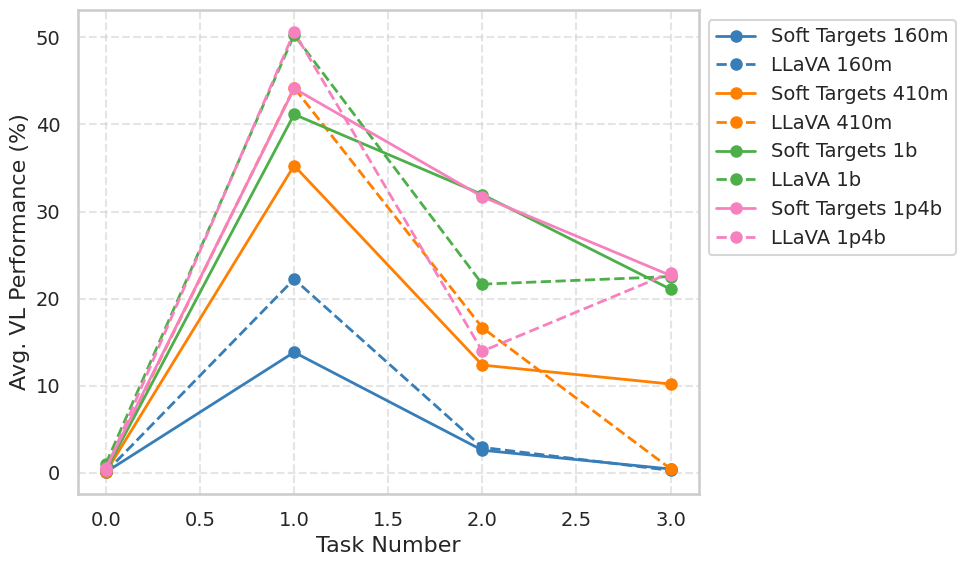

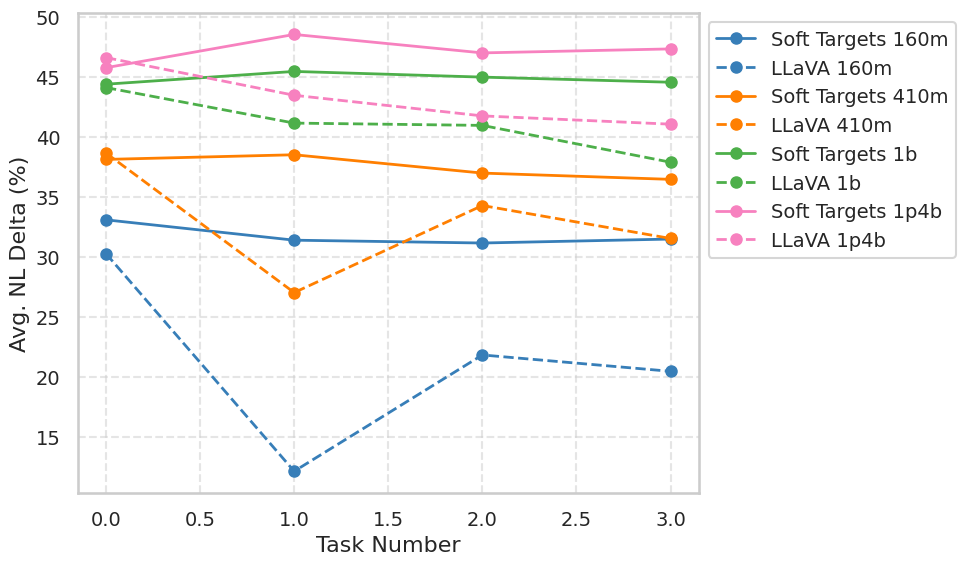

In [1]:
import os
import json
import numpy as np
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define the mitigation methods and their sequence of model names
cl_runs = {
    "naive-ft": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m",
        "cl-ocr-stage-2-pythia+410m",
        "cl-ref-stage-3-pythia+410m"
    ],
    "olf": [
        "cl-instruct-stage-0-pythia+410m-olf",
        "cl-vqa-stage-1-pythia+410m-olf",
        "cl-ocr-stage-2-pythia+410m-olf",
        "cl-ref-stage-3-pythia+410m-olf"
    ],
    "soft": [
        "cl-instruct-stage-0-pythia+410m-soft",
        "cl-vqa-stage-1-pythia+410m-soft",
        "cl-ocr-stage-2-pythia+410m-soft",
        "cl-ref-stage-3-pythia+410m-soft"
    ],
    "ia3": [
        "cl-instruct-stage-0-pythia+410m-ia3",
        "cl-vqa-stage-1-pythia+410m-ia3",
        "cl-ocr-stage-2-pythia+410m-ia3",
        "cl-ref-stage-3-pythia+410m-ia3"
    ],
    "lora": [
        "cl-instruct-stage-0-pythia+410m-lora",
        "cl-vqa-stage-1-pythia+410m-lora",
        "cl-ocr-stage-2-pythia+410m-lora",
        "cl-ref-stage-3-pythia+410m-lora"
    ],
    "sgm": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm",
        "cl-ocr-stage-2-pythia+410m-sgm",
        "cl-ref-stage-3-pythia+410m-sgm"
    ],
    "sgm-olf": [
        "cl-instruct-stage-0-pythia+410m-sgm-olf",
        "cl-vqa-stage-1-pythia+410m-sgm-olf",
        "cl-ocr-stage-2-pythia+410m-sgm-olf",
        "cl-ref-stage-3-pythia+410m-sgm-olf"
    ],
    "rehearsal1": [
        "cl-instruct-stage-0-pythia+410m",
        "cl-vqa-stage-1-pythia+410m-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-rehearsal1",
        "cl-ref-stage-3-pythia+410m-rehearsal1"
    ],
    "sgm-rehearsal1": [
        "cl-instruct-stage-0-pythia+410m-sgm",
        "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1",
        "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1",
        "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"
    ],
}

# Baseline run_id
baseline_run_id = "reproduction-align-pythia+410m"

# Load the JSON data from the results file
with open('results_CL.json', 'r') as file:
    result = json.load(file)

# Check for the existence of baseline results
baseline_results = result.get(baseline_run_id)
if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'stage_{i}'] = change
        performances[f'stage_{i}'] = current_results
        
        vl_scores = np.mean([current_results.get(dataset, np.nan) for dataset in vl_evaluate_sequence[i]])
        baseline_vl_scores = np.mean([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_sequence[i]])
        avg_delta_vl = np.mean(vl_scores) - np.mean(baseline_vl_scores)
        avg_acc_vl = np.mean(vl_scores)
        
        nl_scores = np.mean([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        baseline_nl_scores = np.mean([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
        avg_delta_nl = np.mean(nl_scores) - np.mean(baseline_nl_scores)
        avg_acc_nl = np.mean(nl_scores)
        
        changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
        performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
        print(f"Model: {model_name}, Stage: {i}, VL: {avg_acc_vl}, NL: {avg_acc_nl}")
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

# Generate the LaTeX table
name_mapping = {
    'olf': 'OLF',
    'sgm': 'mSGM',
    'sgm-rehearsal1': 'mSGM + Rehearsal \((1\%)\)',
    'sgm-olf': 'mSGM + OLF',
    'rehearsal1': 'Rehearsal \((1\%)\)',
    'lora': 'LoRA',
    'naive-ft': 'Original LLaVA',
    'soft': 'Soft Targets (ST)',
    'ia3': 'IA3'
}

latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across VL and NL tasks}
  \\label{tab:vl_nl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{2}{c|}{\\textbf{Task 0 (Instruct)}} & \\multicolumn{2}{c|}{\\textbf{Task 1 (VQA)}} & \\multicolumn{2}{c|}{\\textbf{Task 2 (OCR)}} & \\multicolumn{2}{c}{\\textbf{Task 3 (Ref)}} \\\\
     & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} & \\textbf{VL} & \\textbf{NL} \\\\
     & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} & \\textbf{(A $\\uparrow$)} & \\textbf{($\\Delta \\downarrow$)} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
model_name = 'naive-ft'
tasks = cl_performance[model_name]

model_results = (
    name_mapping[model_name],
    tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
    tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
    tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
    tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
)

latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
    model=model_results[0],
    t0_vl_a=model_results[1], t0_nl_d=model_results[2],
    t1_vl_a=model_results[3], t1_nl_d=model_results[4],
    t2_vl_a=model_results[5], t2_nl_d=model_results[6],
    t3_vl_a=model_results[7], t3_nl_d=model_results[8]
)

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue

    model_results = (
        name_mapping[model_name],
        tasks['stage_0_avg']['VL'] * 100, cl_performance_change[model_name]['stage_0_avg']['NL'] * 100,
        tasks['stage_1_avg']['VL'] * 100, cl_performance_change[model_name]['stage_1_avg']['NL'] * 100,
        tasks['stage_2_avg']['VL'] * 100, cl_performance_change[model_name]['stage_2_avg']['NL'] * 100,
        tasks['stage_3_avg']['VL'] * 100, cl_performance_change[model_name]['stage_3_avg']['NL'] * 100
    )
    
    latex_code += "{model} & {t0_vl_a:.2f} & {t0_nl_d:.2f} & {t1_vl_a:.2f} & {t1_nl_d:.2f} & {t2_vl_a:.2f} & {t2_nl_d:.2f} & {t3_vl_a:.2f} & {t3_nl_d:.2f} \\\\\n".format(
        model=model_results[0],
        t0_vl_a=model_results[1], t0_nl_d=model_results[2],
        t1_vl_a=model_results[3], t1_nl_d=model_results[4],
        t2_vl_a=model_results[5], t2_nl_d=model_results[6],
        t3_vl_a=model_results[7], t3_nl_d=model_results[8]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)
